In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import subprocess
%matplotlib inline

In [67]:
def load_x_test():
    return pd.read_csv("./test.csv", index_col="PassengerId")

# Save Kaggle submission file
def submission_df(y_pred):
    X_test = load_x_test()
    return pd.DataFrame(y_pred, index=X_test.index, columns=["Survived"])

def save_submission_file(y_pred, filename):
    df = submission_df(y_pred)
    path = "./" + filename

    try:
        df.to_csv(path)
    except Exception:
        print("Couldn’t save submission.")
    else:
        print("Submission saved.")
        
# Submit score to Kaggle
def submit_predictions(y_pred, filename, message):
    save_submission_file(y_pred, filename)

    completed_process = subprocess.run(
        [
            "kaggle",
            "competitions",
            "submit",
            "-c",
            "titanic",
            "-f",
            filename,
            "-m",
            message
        ], 
        capture_output=True,
        text=True
    )
    
    print(completed_process.stdout)

In [58]:
df = pd.read_csv("./train.csv", index_col="PassengerId")
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [26]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## Describe the data

**Survived**

**Pclass**

> A proxy for socio-economic status (SES):
> - 1st = Upper
> - 2nd = Middle
> - 3rd = Lower
```
>>> np.sort(pd.unique(df["Pclass"]))
array([1, 2, 3])
```

**Name**

The name of the passenger.


**Sex**

> Sex
```
>>> np.sort(pd.unique(df["Sex"]))
array(['female', 'male'], dtype=object)
```

**Age**

> Age in years. Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
```
>>> np.sort(pd.unique(df["Age"]))
array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,
        5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  ,
       14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 20.5 ,
       21.  , 22.  , 23.  , 23.5 , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 30.5 , 31.  , 32.  , 32.5 , 33.  ,
       34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  ,
       48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  , 55.5 ,
       56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 63.  , 64.  ,
       65.  , 66.  , 70.  , 70.5 , 71.  , 74.  , 80.  ,   nan])
```

**SibSp**

> \# of siblings / spouses aboard the Titanic. The dataset defines family relations in this way:

> Sibling = brother, sister, stepbrother, stepsister

> Spouse = husband, wife (mistresses and fiancés were ignored)

This is a little weird, but you basically get a number of *either* siblings *or* spouses:
```
>>> np.sort(pd.unique(df["SibSp"]))
array([0, 1, 2, 3, 4, 5, 8])
```

**Parch**

> \# of parents / children aboard the Titanic. The dataset defines family relations in this way:

> - Parent = mother, father
> - Child = daughter, son, stepdaughter, stepson
> - Some children travelled only with a nanny, therefore parch=0 for them.
```
>>> np.sort(pd.unique(df["Parch"]))
array([0, 1, 2, 3, 4, 5, 6])
```

**Ticket**

> Ticket number

**Fare**

> Passenger fare

**Cabin**

> Cabin number

**Embarked**

> Port of embarkation
> - C = Cherbourg
> - Q = Queenstown
> - S = Southampton
```
>>> pd.unique(df["Embarked"])
array(['S', 'C', 'Q', nan], dtype=object)
```

array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

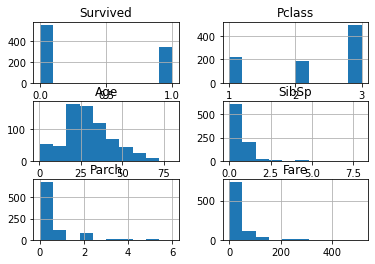

In [24]:
df.hist()

<AxesSubplot:xlabel='Fare', ylabel='Count'>

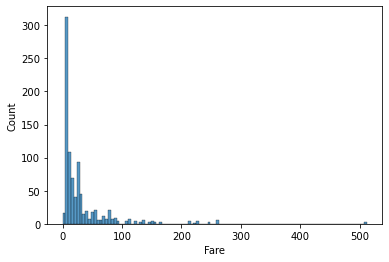

In [28]:
sns.histplot(data=df, x="Fare")

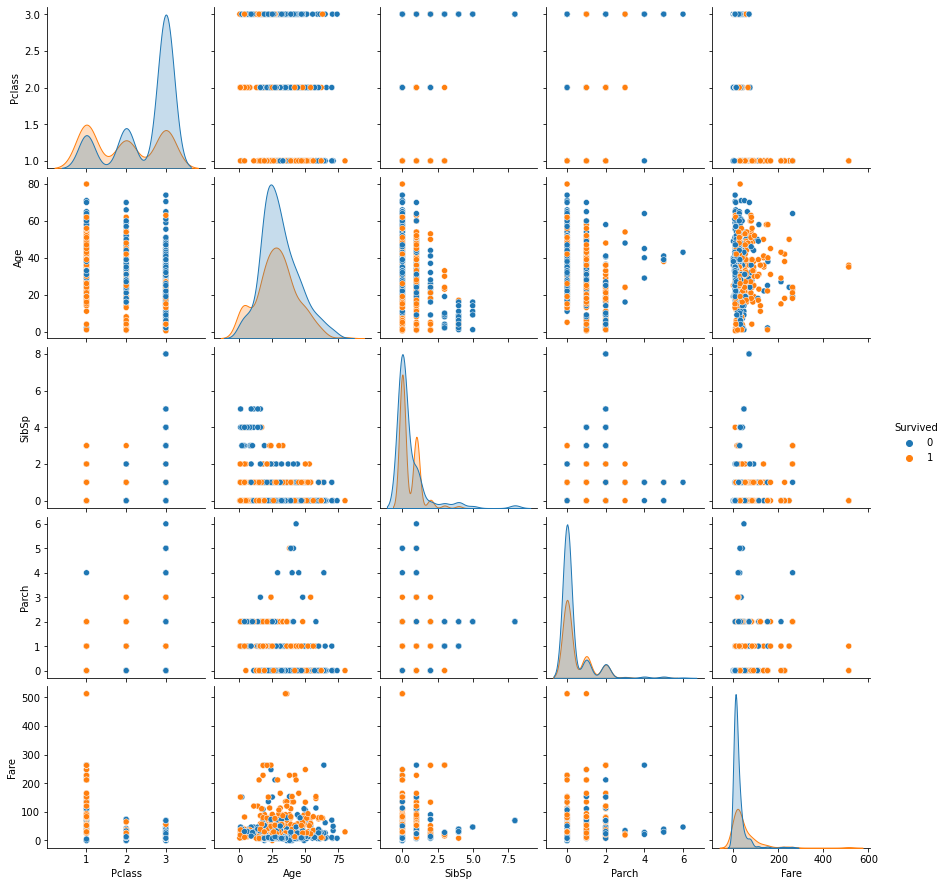

In [29]:
sns.pairplot(data=df, hue="Survived")

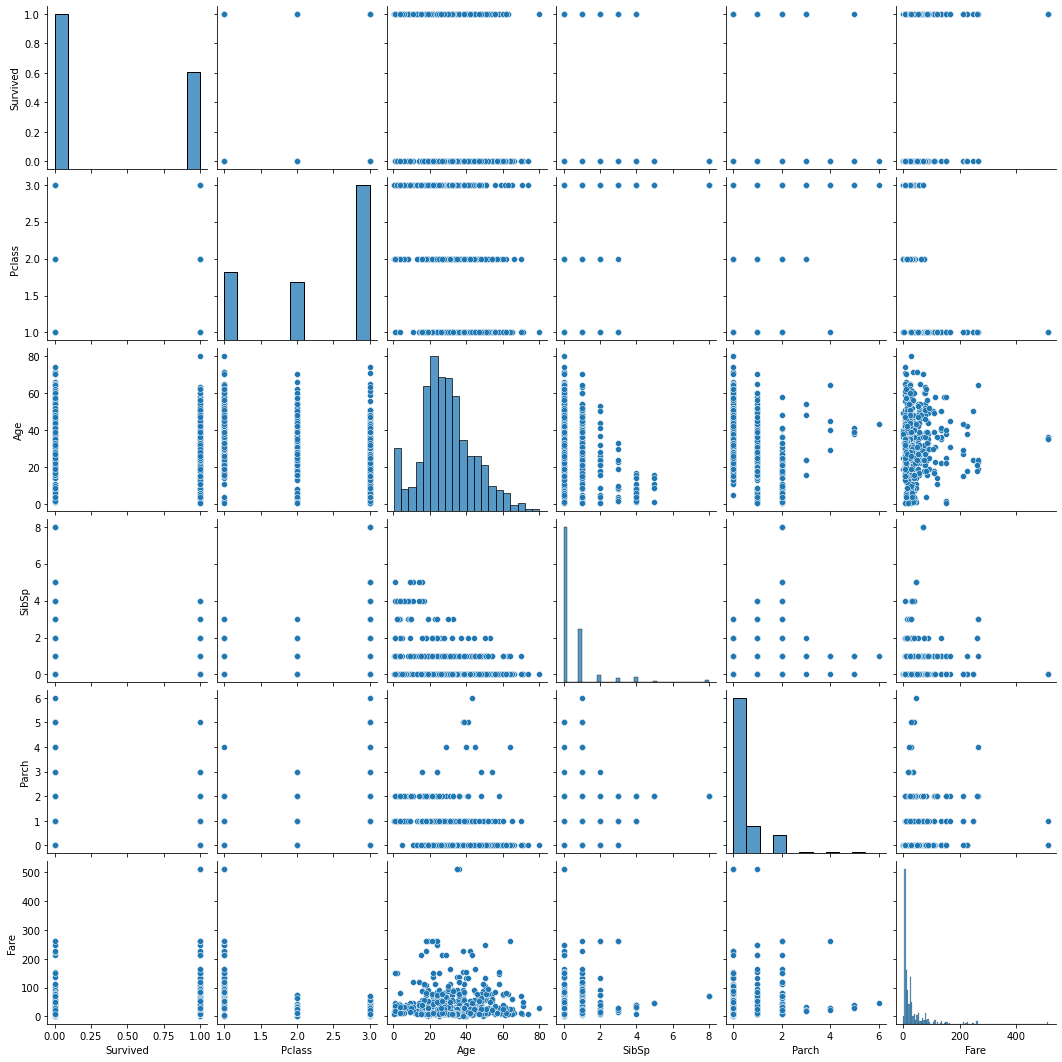

In [30]:
sns.pairplot(data=df)

In [35]:
len(df.index)

891

In [33]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [45]:
X_train, y_train = df.loc[:, "Pclass":], df.loc[:, "Survived"]

In [46]:
X_train

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [47]:
y_train

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

In [ ]:
X_train

In [48]:
def get_pipe(model):
    numeric_pipe = Pipeline([
        ('impute_missing_numeric_values', SimpleImputer(strategy="median")),
        ('standard_scaler', StandardScaler())
    ])

    categorical_pipe = Pipeline([
        ('impute_missing_categorical_values', SimpleImputer(strategy="constant", fill_value="Unknown")),
        ('standard_scaler', OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessing = ColumnTransformer([
        ('numeric', numeric_pipe, make_column_selector(dtype_include=np.number)),
        ('categorical', categorical_pipe, make_column_selector(dtype_include=object))
    ],
    n_jobs=-1)
    
    pipe = Pipeline([
        ("preprocessing", preprocessing),
        ("model", model)
    ])
    
    return pipe

In [54]:
model = LogisticRegression(random_state=42)
pipe = get_pipe(model)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('impute_missing_numeric_values',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ffd571e0d60>),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute_missing_categorical_values',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('s

In [55]:
pipe.score(X_train, y_train)

0.9259259259259259

In [61]:
X_test = pd.read_csv("./test.csv", index_col="PassengerId")
X_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [62]:
y_pred = pipe.predict(X_test)

In [70]:
submit_predictions(
    y_pred, 
    "01-plain-submission-for-benchmarking.csv",
    "First submission without any real analysis or data transformation."\
    " Trained with plain LogisticRegression. For benchmarking purposes.")

Submission saved.
Successfully submitted to Titanic: Machine Learning from Disaster
